# Thermodynamic Analysis

## Purpose

* To determine if our two aerobic FBA solutions are spontaneous overall and compare their $\Delta G^{'}_m$

* To run an MDF simulation with `equilibrator_pathway` and compare these solutions' MDF's, most spontaneous steps, and least spontaneous steps.

## Load up packages and read in FBA results

In [24]:
#load up everything
%matplotlib inline
import cobra
from cobra import Model, Reaction, Metabolite
cobra_config = cobra.Configuration()
import escher
from escher import Builder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import cobra.test
import equilibrator_api
from equilibrator_api import Q_
from equilibrator_api import get_compound
import math
from sbtab import SBtab
from equilibrator_pathway import Pathway

network = pd.read_csv('shikimate_reactions.csv' , header=0)#shikimate related reactions to add
sinks = pd.read_csv('sinks.csv' , header=0)#sinks to add

levdopa_synthesis = cobra.io.load_json_model("e_coli_core.json")#e coli central metabolism model from BiGG
#levdopa_synthesis.solver = 'cplex'

#define intracellular reactions not in central metabolism model
for (myenzyme , mypathway , myreaction) in network.itertuples(index = False):
    rxn = Reaction(myenzyme)
    levdopa_synthesis.add_reactions([rxn])
    rxn.name = myenzyme
    rxn.subsystem = mypathway
    rxn.build_reaction_from_string(myreaction)

#define extra transport reactions not in central metabolism model
for (mymetabolite , mydirection) in sinks.itertuples(index = False):
    myreaction = '%s -->' % mymetabolite
    rxn = Reaction('EX_%s' % mymetabolite)
    levdopa_synthesis.add_reactions([rxn])
    rxn.subsystem = 'Extracellular exchange'
    rxn.name = '%s_transport' % mymetabolite
    rxn.build_reaction_from_string(myreaction)
    rxn.lower_bound = 0.
    rxn.upper_bound = 1000.

solution = pd.read_csv('FBA_results/aerobic.csv' , index_col = 0)
solution_glutamate = pd.read_csv('FBA_results/aerobic_glutamate.csv' , index_col = 0)
solution_anaerobic = pd.read_csv('FBA_results/anaerobic.csv' , index_col = 0)

unknown metabolite 'dahp_c' created
unknown metabolite 'dhq_c' created
unknown metabolite '3dhs_c' created
unknown metabolite 'shikimate_c' created
unknown metabolite 'shikimate3p_c' created
unknown metabolite 'epsp_c' created
unknown metabolite 'chorismate_c' created
unknown metabolite 'prephenate_c' created
unknown metabolite '4hppa_c' created
unknown metabolite 'tyr__L_c' created
unknown metabolite 'levdopa_c' created
unknown metabolite 'levdopa_e' created


## KEGG ID stuff
Import the *E. coli* core metabolism json and extract the metabolites section. Then, define a function that takes a BiGG metabolite ID and spits out the corresponding KEGG ID.

Also write a function that takes a reaction from the Cobra model (with our BiGG-format ID's) and turns it into a Equilibrator-readable reaction.

In [25]:
#Import e coli core model in json format
import json
with open('e_coli_core.json') as f:
    ecolicore = json.load(f)
metabolites = ecolicore['metabolites']

custom_metabolites = pd.read_csv('shikimate_metabolites.csv' , index_col = 0)

#Returns KEGG ID for a given BiGG ID
def getKEGG(met_id):
    #Search for metabolite by BiGG ID in the e coli core model
    entry = list(filter(lambda met: met['id'] == met_id, metabolites))
    #If we get a hit, return it
    try:
        return entry[0]['annotation']['kegg.compound'][0]
    #If else, it's probably one of my custom metabolites
    except:
        return custom_metabolites.at[met_id , 'KEGG_ID']
    

#Takes a reaction object and converts it into an Equilibrator-parsable string
def stringReaction(rxn , for_pathway = False):
    left = {met : stoich for met , stoich in rxn.metabolites.items() if stoich < 0}
    right = {met : stoich for met , stoich in rxn.metabolites.items() if stoich > 0}
    rxn_string = ''
    
    if not for_pathway:
        for met , stoich in left.items():
            rxn_string += '%.2f kegg:%s + ' % (-1*stoich , getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string)-2] + '= '
        for met , stoich in right.items():
            rxn_string += '%.2f kegg:%s + ' % (stoich , getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string) - 3]
    else:
        #return in equilibrator pathway-happy format if you so request. (no kegg or leading 1's)
        for met , stoich in left.items():
            if abs(stoich) != 1:
                rxn_string += '%.2f %s + ' % (-1*stoich , getKEGG(met.id))
            else:
                rxn_string += '%s + ' % (getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string)-2] + '<=> '
        for met , stoich in right.items():
            if abs(stoich) != 1:
                rxn_string += '%.2f %s + ' % (stoich , getKEGG(met.id))
            else:
                rxn_string += '%s + ' % (getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string) - 3]
    return(rxn_string)
        

## dGo and dGm Helper Function

This function queries equilibrator for all reactions in a flux vector, inverting the sign of the resulting dG if the corresponding flux is negative. It can find either dGo or dGm. Results are returned as a dataframe of the value and error for each reaction. Transport and exchange reactions are ignored!

In [26]:
#Gets delta go or delta gm for each reaction in a data frame
def getG(flux_df , useGm = False):
    #this will store the string form g values and the indices in parallel arrays
    g = []
    indices = []
    #iterate over every reaction that isn't an exchange or transport
    for rxn in flux_df.index:
        if rxn.rfind('EX_') < 0 and rxn.rfind('_t') < 0 and rxn != 'H2Ot' and rxn != 'NH4t' and rxn != 'CO2t' and rxn != 'O2t':
            #flip the signs of reactions with negative fluxes
            if flux_df.loc[rxn , 'fluxes'] < 0:
                flip_sign = -1
            else:
                flip_sign = 1
            try:
                #make equilibrator model of reaction
                s = stringReaction(levdopa_synthesis.reactions.get_by_id(rxn))
                reaction = equilibrator_api.parse_reaction_formula(s)
                cc = equilibrator_api.ComponentContribution(p_h=Q_(7.0), temperature=Q_("298.15K"))
                # calculate standard free energy
                if not useGm:
                    g.append(flip_sign * cc.standard_dg_prime(reaction))
                #calculate metabolic free energy
                else:
                    g.append(flip_sign * cc.physiological_dg_prime(reaction))
            except:
                print('Failed to add reaction %s' % rxn)
                g.append(None)
            indices.append(rxn)
    #extract magnitudes and errors from string form g
    magnitudes = []
    errors = []
    for a in g:
        if a is None:
            magnitudes.append(None)
            errors.append(None)
        else:
            magnitudes.append(float(str(a.magnitude)[0:str(a.magnitude).rfind('+')]))
            errors.append(float(str(a.magnitude)[str(a.magnitude).rfind('-')+1:]))
    #return result as data frame
    if useGm:
        cols = ['dGm_kJ_per_mol' , 'error']
    else:
        cols = ['dGo_kJ_per_mol' , 'error']
    result = pd.DataFrame(zip(magnitudes , errors) , index = indices , columns = cols)
    return result
    

## Overall Pathway Thermodynamics of FBA Solutions

Use the `getG()` function above to calculate the dGm for each step in our flux solutions. Then, for each flux solution, multiply each reaction's dGm (kJ/mol) by its pathway's relative flux (mol/arbitrary time unit, assumed to be mol/min for this) and sum to get the overall dGm of the reaction.

Normalize these by the flux of L-DOPA synthesis to get a result in units of kJ/mol L-DOPA synthesized so that we can compare across flux solutions!

In [27]:
#Aerobic solution
print('Aerobic Solution')
Gm = getG(solution , useGm = True)
nonspontaneous = Gm.query('dGm_kJ_per_mol > 0').sort_values(by='dGm_kJ_per_mol' , ascending = False)
spontaneous = Gm.query('dGm_kJ_per_mol <= 0').sort_values(by='dGm_kJ_per_mol')

dGm_overall = 0
for index , row in Gm.iterrows():
    if not math.isnan(row['dGm_kJ_per_mol']):
        dGm_overall += row['dGm_kJ_per_mol'] * abs(solution.loc[index , 'fluxes'])
print('Total dGm of flux vector: %f kJ/min' % dGm_overall)
print('Normalized to L-DOPA production: %f kJ/mol L-DOPA' % (float(dGm_overall) / abs(solution.loc['EX_levdopa_e' , 'fluxes'])))

Aerobic Solution
Total dGm of flux vector: -8916.193232 kJ/min
Normalized to L-DOPA production: -1754.361105 kJ/mol L-DOPA


In [28]:
#Aerobic + glutamate solution
print('Aerobic Solution with Glutamate Feed')
Gm_glu = getG(solution_glutamate , useGm = True)
nonspontaneous_glu = Gm_glu.query('dGm_kJ_per_mol > 0').sort_values(by='dGm_kJ_per_mol' , ascending = False)
spontaneous_glu = Gm_glu.query('dGm_kJ_per_mol <= 0').sort_values(by='dGm_kJ_per_mol')

dGm_overall_glu = 0
for index , row in Gm_glu.iterrows():
    if not math.isnan(row['dGm_kJ_per_mol']):
        dGm_overall_glu += row['dGm_kJ_per_mol'] * abs(solution_glutamate.loc[index , 'fluxes'])
print('Total dGm of flux vector: %f kJ/min' % dGm_overall_glu)
print('Normalized to L-DOPA production: %f kJ/mol L-DOPA' % (float(dGm_overall_glu) / abs(solution_glutamate.loc['EX_levdopa_e' , 'fluxes'])))

Aerobic Solution with Glutamate Feed
Total dGm of flux vector: -300455.460008 kJ/min
Normalized to L-DOPA production: -1945.646601 kJ/mol L-DOPA


## Max-Min Driving Force
First, we need to convert into the kinds of CSV files that the Equilibrator sbtab converter requires.

In [29]:
#Export solution as an Equilibrator Pathway-compatible CSV file
def makeCSV(flux_df , filename):
    reaction_names = [stringReaction(levdopa_synthesis.reactions.get_by_id(rxn) , for_pathway = True) for rxn in flux_df.index]
    result = pd.DataFrame(zip(reaction_names , flux_df.fluxes.values), columns = ['ReactionFormula' , 'RelativeFlux'])
    result.to_csv('Equilibrator_Pathway_CSV/%s' % filename , index = False)
#Run this function for the shikimate pathway. Only put in the rows that aren't sinks or passive transports.
shikimate_rxns = [r.name for r in levdopa_synthesis.reactions if r.subsystem == 'shikimate_pathway' or r.subsystem == 'tyrosine_metabolism']
shikimate_fluxes = solution.loc[shikimate_rxns,'fluxes'] / solution.loc['hpaBC','fluxes']
shikimate_rxns = pd.DataFrame(shikimate_fluxes.values , index = shikimate_rxns , columns = ['fluxes'])
#Only worry about the NADH-dependent shikimate dehydrogenase for this analysis.
shikimate_rxns = shikimate_rxns.drop(['shikimate_dh'])
shikimate_rxns.at['shikimate_dh_nadh','fluxes'] = 1
makeCSV(shikimate_rxns , 'shikimate.csv')
#Make CSV files for the aerobic and aerobic+glutamate FBA solutions (scrub out sinks and passive transports)
exchange_reactions = ['EX_for_e','EX_pi_e','PIt2r','EX_co2_e','FORti','EX_glc__D_e','EX_h_e','EX_h2o_e','EX_nh4_e','EX_o2_e','CO2t','NH4t','H2Ot','O2t','levdopa_t','EX_levdopa_e','EX_glu__L_e','GLUt2r']
makeCSV(solution.query('not index in @exchange_reactions')  , 'solution.csv')
makeCSV(solution_glutamate.query('not index in @exchange_reactions')  , 'solution_glutamate.csv')

*__brief detour to the equilibrator website to make an `sbtab`__*

Make the following modifications to the output, because the equilibrator website is silly:
* change the 'RelativeFluxes' table to 'Fluxes'
* change the columns 'Concentrations!Min' and 'Concentrations!Max' to 'Min' and 'Max'
* remove R00086 (ATP synthase, i.e. nickel tra) because the ATP:ADP ratio is fixed and the pathway tool can't distinguish between intracellular and extracellular H+, making this reaction seem **MASSIVELY** endergonic.

## Shikimate Pathway Alone

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12 UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


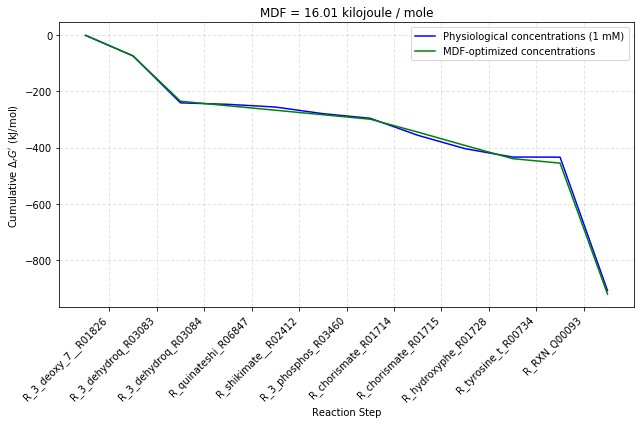

In [51]:
#Read in resulting sbtab
filename = 'Equilibrator_Pathway_CSV/shikimate_pH7.00_I0.10_MDF.tsv'
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("shikimate_pH7.00_I0.10_MDF", file_content, filename)
#Run mdf analysis
shikimate_pathway = Pathway.from_sbtab(doc)
shikimate_mdf_result = shikimate_pathway.calc_mdf()
#Plot output
plt = shikimate_mdf_result.reaction_plot;
plt.show()
plt.savefig('figures/shikimate_mdf.png')

### Enzymes Sorted by Biggest dG Drop

In [45]:
shikimate_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime'] , ascending = True)

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
10,R_RXN_Q00093,"Compound(id=7, inchi_key=MYMOFIZGZYHOMD-UHFFFA...",1.0 millimolar / second,-492.65071500588675 kilojoule / mole,-475.53587747116575 kilojoule / mole,-451.000864904578 kilojoule / mole,0.0
1,R_3_dehydroq_R03083,"Compound(id=1126, inchi_key=PJWIPEXIFFQAQZ-PUF...",1.0 millimolar / second,-150.2757188641873 kilojoule / mole,-167.39055639890833 kilojoule / mole,-161.6856105540013 kilojoule / mole,0.0
0,R_3_deoxy_7__R01826,"Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFA...",1.0 millimolar / second,-73.13031621623065 kilojoule / mole,-73.13031621623065 kilojoule / mole,-73.13031621623065 kilojoule / mole,0.0
7,R_chorismate_R01715,"Compound(id=319, inchi_key=WTFXTQVDAKGDEY-HTQZ...",1.0 millimolar / second,-47.84913782567853 kilojoule / mole,-47.84913782567853 kilojoule / mole,-47.84913782567853 kilojoule / mole,0.0
8,R_hydroxyphe_R01728,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",1.0 millimolar / second,-12.605098239751324 kilojoule / mole,-29.719935774472358 kilojoule / mole,-46.8347733091934 kilojoule / mole,0.0
6,R_chorismate_R01714,"Compound(id=1247, inchi_key=QUTYKIXIUDQOLK-PRJ...",1.0 millimolar / second,-43.3833539611398 kilojoule / mole,-60.49819149586082 kilojoule / mole,-45.782897516473206 kilojoule / mole,0.0
4,R_shikimate__R02412,"Compound(id=6, inchi_key=ZKHQWZAMYRWXGA-KQYNXX...",1.0 millimolar / second,-23.535582752598216 kilojoule / mole,-23.535582752598216 kilojoule / mole,-16.006844768228476 kilojoule / mole,0.0
2,R_3_dehydroq_R03084,"Compound(id=456, inchi_key=WVMWZWGZRAXUBK-SYTV...",1.0 millimolar / second,-5.290204863241644 kilojoule / mole,-5.290204863241644 kilojoule / mole,-16.00684476822847 kilojoule / mole,0.5
3,R_quinateshi_R06847,"Compound(id=13, inchi_key=BOPGDPNILDQYTO-NNYOX...",1.0 millimolar / second,-9.608647138494256 kilojoule / mole,-9.608647138494256 kilojoule / mole,-16.00684476822847 kilojoule / mole,0.5
5,R_3_phosphos_R03460,"Compound(id=70, inchi_key=DTBNBXWJWCWCIK-UHFFF...",1.0 millimolar / second,-16.582596184099152 kilojoule / mole,-16.582596184099152 kilojoule / mole,-16.00684476822847 kilojoule / mole,0.0


## Aerobic/Ammonia FBA Solution

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12 UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


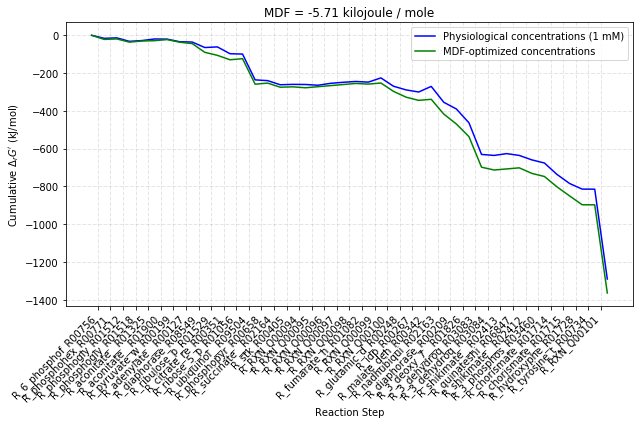

In [50]:
#Read in resulting sbtab
filename = 'Equilibrator_Pathway_CSV/solution_pH7.00_I0.10_MDF.tsv'
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("solution_pH7.00_I0.10_MDF", file_content, filename)
#Run mdf analysis
solution_pathway = Pathway.from_sbtab(doc)
solution_mdf_result = solution_pathway.calc_mdf()
#Plot output
plt = solution_mdf_result.reaction_plot;
plt.show()
plt.savefig('figures/aerobic_mdf.png')

### Bottleneck Enzymes

In [39]:
solution_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime'] , ascending = False).query('optimized_dg_prime > 0')

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
17,R_RXN_Q00095,"Compound(id=109, inchi_key=KTVPXOYAKDPRHY-SOOF...",1.694100719 millimolar / second,-3.8676911569980366 kilojoule / mole,-3.8676911569980366 kilojoule / mole,5.710508910818351 kilojoule / mole,7.037479e-18
13,R_phosphopyr_R00658,"Compound(id=261, inchi_key=GXIURPTVHJPJLF-UWTA...",13.22359712 millimolar / second,-4.085902336476765 kilojoule / mole,-4.085902336476765 kilojoule / mole,5.710508910818346 kilojoule / mole,0.000000e+00
20,R_RXN_Q00098,"Compound(id=396, inchi_key=RNBGYGVWRKECFJ-VRPW...",8.305899281 millimolar / second,21.442038364088244 kilojoule / mole,4.3272008293672135 kilojoule / mole,5.710508910818342 kilojoule / mole,3.086803e-16
19,R_RXN_Q00097,"Compound(id=74, inchi_key=GNGACRATGGDKBX-UHFFF...",8.305899281 millimolar / second,5.485501104913026 kilojoule / mole,5.485501104913026 kilojoule / mole,5.7105089108183416 kilojoule / mole,3.086803e-16
33,R_quinateshi_R06847,"Compound(id=13, inchi_key=BOPGDPNILDQYTO-NNYOX...",7.105611511 millimolar / second,-9.608647138494256 kilojoule / mole,-9.608647138494256 kilojoule / mole,5.710508910818341 kilojoule / mole,5.000000e-01
18,R_RXN_Q00096,"Compound(id=176, inchi_key=FNZLKVNUWIIPSJ-RFZP...",-3.388201439 millimolar / second,10.025766454187083 kilojoule / mole,10.025766454187083 kilojoule / mole,5.710508910818341 kilojoule / mole,1.193585e-15
26,R_malate_deh_R00342,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",3.058992806 millimolar / second,29.665838593927084 kilojoule / mole,29.665838593927084 kilojoule / mole,5.710508910818338 kilojoule / mole,4.554230e-17
22,R_RXN_Q00099,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",13.22359712 millimolar / second,5.233896006863752 kilojoule / mole,22.34873354158478 kilojoule / mole,5.7105089108183344 kilojoule / mole,-5.551115e-16
3,R_phosphogly_R01518,"Compound(id=261, inchi_key=GXIURPTVHJPJLF-UWTA...",-13.22359712 millimolar / second,4.1884166314404405 kilojoule / mole,4.1884166314404405 kilojoule / mole,5.710508910818334 kilojoule / mole,0.000000e+00
32,R_shikimate__R02413,"Compound(id=9, inchi_key=ACFIXJIJDZMPPO-NNYOXO...",-2.023309353 millimolar / second,9.619773270316877 kilojoule / mole,9.619773270316877 kilojoule / mole,5.710508910818334 kilojoule / mole,5.000000e-01


### Five Enzymes with Biggest dG Drop

In [43]:
solution_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime']).head(5)

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
40,R_RXN_Q00101,"Compound(id=7, inchi_key=MYMOFIZGZYHOMD-UHFFFA...",5.082302158 millimolar / second,-492.65071500588675 kilojoule / mole,-475.53587747116575 kilojoule / mole,-466.61427006229053 kilojoule / mole,0.0
30,R_3_dehydroq_R03083,"Compound(id=1126, inchi_key=PJWIPEXIFFQAQZ-PUF...",5.082302158 millimolar / second,-150.2757188641873 kilojoule / mole,-167.39055639890833 kilojoule / mole,-161.6856105540013 kilojoule / mole,0.0
12,R_ubiquinol__R09504,"0.5 Compound(id=7, inchi_key=MYMOFIZGZYHOMD-UH...",18.35395683 millimolar / second,-145.0800963134631 kilojoule / mole,-136.52267754610256 kilojoule / mole,-134.91434676411848 kilojoule / mole,0.0
27,R_nadhubiqui_R02163,"Compound(id=13, inchi_key=BOPGDPNILDQYTO-NNYOX...",15.29496403 millimolar / second,-84.0151476079217 kilojoule / mole,-84.0151476079217 kilojoule / mole,-78.3102017630147 kilojoule / mole,0.0
29,R_3_deoxy_7__R01826,"Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFA...",5.082302158 millimolar / second,-73.13031621623065 kilojoule / mole,-73.13031621623065 kilojoule / mole,-66.76674369408664 kilojoule / mole,0.0


## Aerobic/Glutamate FBA Solution

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12 UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


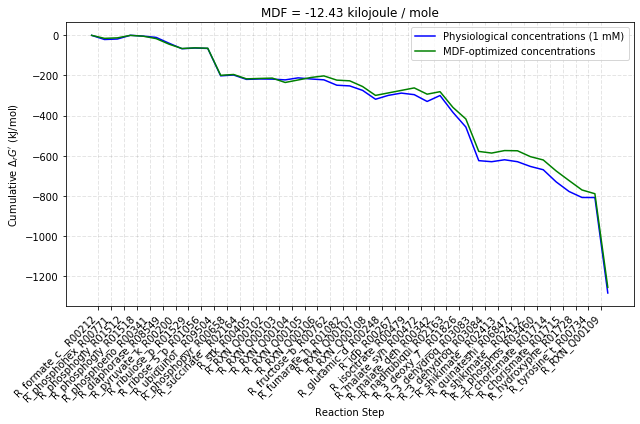

In [49]:
#Read in resulting sbtab
filename = 'Equilibrator_Pathway_CSV/solution_glutamate_pH7.00_I0.10_MDF.tsv'
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("solution_glutamate_pH7.00_I0.10_MDF", file_content, filename)
#Run mdf analysis
solution_glu_pathway = Pathway.from_sbtab(doc)
solution_glu_mdf_result = solution_glu_pathway.calc_mdf()
#Plot output
plt = solution_glu_mdf_result.reaction_plot;
plt.show()
plt.savefig('figures/glutamate_mdf.png')

### Bottleneck Enzymes

In [42]:
solution_glu_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime'] , ascending = False).query('optimized_dg_prime > 0')

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
26,R_malate_deh_R00342,"Compound(id=11, inchi_key=BAWFJGJZGIEFAR-NNYOX...",978.9930348 millimolar / second,29.665838593927084 kilojoule / mole,29.665838593927084 kilojoule / mole,12.427482538973871 kilojoule / mole,1.834180e-17
24,R_isocitrate_R00479,"Compound(id=74392, inchi_key=ODBLHEXUDAPZAU-UH...",484.2447761 millimolar / second,9.420781153067109 kilojoule / mole,-7.6940563816539225 kilojoule / mole,12.42748253897386 kilojoule / mole,0.000000e+00
23,R_idp_R00267,"Compound(id=8, inchi_key=XJLXINKUBYWONI-NNYOXO...",-484.2447761 millimolar / second,-5.905638020781567 kilojoule / mole,11.209199513939463 kilojoule / mole,12.42748253897386 kilojoule / mole,5.000000e-01
22,R_glutamic_d_R00248,"Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFA...",340.3237811 millimolar / second,36.46554894363627 kilojoule / mole,19.35071140891524 kilojoule / mole,12.427482538973857 kilojoule / mole,5.000000e-01
15,R_RXN_Q00104,"Compound(id=176, inchi_key=FNZLKVNUWIIPSJ-RFZP...",-102.9496517 millimolar / second,10.025766454187083 kilojoule / mole,10.025766454187083 kilojoule / mole,12.427482538973857 kilojoule / mole,0.000000e+00
2,R_phosphogly_R01512,"Compound(id=6, inchi_key=ZKHQWZAMYRWXGA-KQYNXX...",185.8993035 millimolar / second,18.50164514567255 kilojoule / mole,18.50164514567255 kilojoule / mole,12.427482538973855 kilojoule / mole,0.000000e+00
31,R_shikimate__R02413,"Compound(id=9, inchi_key=ACFIXJIJDZMPPO-NNYOXO...",-143.920995 millimolar / second,9.619773270316877 kilojoule / mole,9.619773270316877 kilojoule / mole,12.427482538973843 kilojoule / mole,0.000000e+00
16,R_RXN_Q00105,"Compound(id=74, inchi_key=GNGACRATGGDKBX-UHFFF...",-41.47482587 millimolar / second,-5.485501104913026 kilojoule / mole,-5.485501104913026 kilojoule / mole,12.42748253897384 kilojoule / mole,-3.348544e-18
17,R_RXN_Q00106,"Compound(id=396, inchi_key=RNBGYGVWRKECFJ-VRPW...",-41.47482587 millimolar / second,-21.442038364088244 kilojoule / mole,-4.3272008293672135 kilojoule / mole,7.880836969612569 kilojoule / mole,-3.348544e-18
10,R_phosphopyr_R00658,"Compound(id=261, inchi_key=GXIURPTVHJPJLF-UWTA...",-185.8993035 millimolar / second,4.085902336476765 kilojoule / mole,4.085902336476765 kilojoule / mole,4.085902336476772 kilojoule / mole,-3.239090e-33


### Five Enzymes with Biggest dG Drop

In [44]:
solution_glu_mdf_result.reaction_df.sort_values(by=['optimized_dg_prime']).head(5)

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
39,R_RXN_Q00109,"Compound(id=7, inchi_key=MYMOFIZGZYHOMD-UHFFFA...",154.4244776 millimolar / second,-492.65071500588675 kilojoule / mole,-475.53587747116575 kilojoule / mole,-466.61427006229053 kilojoule / mole,0.0
29,R_3_dehydroq_R03083,"Compound(id=1126, inchi_key=PJWIPEXIFFQAQZ-PUF...",154.4244776 millimolar / second,-150.2757188641873 kilojoule / mole,-167.39055639890833 kilojoule / mole,-161.6856105540013 kilojoule / mole,0.0
9,R_ubiquinol__R09504,"0.5 Compound(id=7, inchi_key=MYMOFIZGZYHOMD-UH...",1000.0 millimolar / second,-145.0800963134631 kilojoule / mole,-136.52267754610256 kilojoule / mole,-134.91434676411848 kilojoule / mole,0.0
27,R_nadhubiqui_R02163,"Compound(id=13, inchi_key=BOPGDPNILDQYTO-NNYOX...",505.2517413 millimolar / second,-84.0151476079217 kilojoule / mole,-84.0151476079217 kilojoule / mole,-78.31020176301472 kilojoule / mole,0.0
28,R_3_deoxy_7__R01826,"Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFA...",154.4244776 millimolar / second,-73.13031621623065 kilojoule / mole,-73.13031621623065 kilojoule / mole,-57.619048657130605 kilojoule / mole,0.0


## Discussion

The shikimate pathway is spontaneous overall, and can be optimized to have entirely spontaneous steps, even with Equilibrator Pathway's very tight cofactor balance constraints. Within the physiological and MDF-optimized thermodynamic landscapes, hpaBC, dehydroquinate synthase, and DAHP synthase had noticeably large $\Delta G$. It's nice to have our final pathway step, hpaBC, have such a large driving force. Thermochemically, this is likely because the reaction effectively combusts oxygen gas into water! DAHP synthase and dehydroquinate synthase are the first two steps in the shikimate pathway. Since these reactions are very spontaneous, they have a $K_{eq}$ far from equilibrium, and thus large flux control coefficients. If we want to maximize flux into this pathway to maximize our L-DOPA yield, it could make sense to upregulate activity of these enzymes. We could do this through promoter replacement, gene duplication, or heterologous enzyme addition or protein engineering to reduce allosteric inhibition.

From a net thermodynamic perspective, the glutamate-dependent FBA solution yields a larger $\Delta G$ drop than the ammonia-dependent FBA solution by a couple hundred kJ/mol. This is likely because it runs a lot more electron transport chain activity, and produces lots of extra, highly reduced carbon dioxide (from PEPCK) and formate (from PFL). Its lower carbon efficiency translates to more thermodynamic driving force.

However, looking at the MDF calculations yields a slightly different persepctive. Both the glutamate-dependent and ammonia-dependent FBA solutions have slightly negative minimum driving forces, due to the tight cofactor concentration constraints imposed by Equilibrator Pathway. These negative MDFs are reasonably close to zero, though, and close to Equilibrator's stated margin of error; our flux balance solutions are therefore by no means unfeasible. The ammonia-dependent solution has a more spontaneous MDF than does the glutamate-dependent solution.

The ammonia-dependent solution's bottleneck reactions are enoalse (we need a **lot** of PEP to drive the shikimate pathway) and a few of the intermediate, closer-to-equilibrium reactions of the shikimate pathway. (We can't maximize the concentrations of carbon inputs as we could when analyzing the shikimate pathway alone, due to constraints from glycolysis and the pentose phosphate pathway.

The glutamate-dependent solution has a tigher bottleneck. Isocitrate oxidoreductase, malate dehydrogenase, and other nearby enzymes were the culprits for this unspontanaeity. This suggests the bottleneck is due to the solution's heavy reliance on the glyoxylate shunt. (It doesn't have a reputation for being very thermodynamically favorable!)

The two FBA solution MDF results yielded three of the same most spontaneous enzymes as analysis of the shikimate pathway alone did: hpaBC, dehydroquinate synthase, and DAHP synthase. This again succests that these enzymes may be good targets for future strain engineering efforts. Other most spontaneous enzymes from these pathways were (unsurprisingly) associated with the electron transport chain. (_In vivo_, free energy from these reactions is used to pump hydrogen ions for use in ATP synthesis.) 